# Predicting whether a person will default on their premium

Importing necessary libraries

In [1]:
# Data Wrangling 
import numpy as np
import pandas as pd 

# Data Visualisation 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

# Machine Learning 
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron 
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

Read data into dataframes 

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
combine = [train_data, test_data]

## EDA 

In [3]:
train_data.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [4]:
test_data.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural


In [5]:
train_data.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,target
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [6]:
train_data.describe(percentiles = [.08, .07, .06])

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,target
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
6%,6934.240000,0.000000,10959.000000,5.795120e+04,0.000000,0.000000,0.000000,97.940000,4.000000,1200.000000,0.000000
7.0%,8075.280000,0.000000,11321.000000,6.012000e+04,0.000000,0.000000,0.000000,98.060000,5.000000,1200.000000,1.000000
8%,9184.320000,0.001000,11329.000000,6.380000e+04,0.000000,0.000000,0.000000,98.150000,5.000000,1200.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


**Inference**

* 93% of the people have paid their premiums. 
* The age of people is very varied between 21 and 103

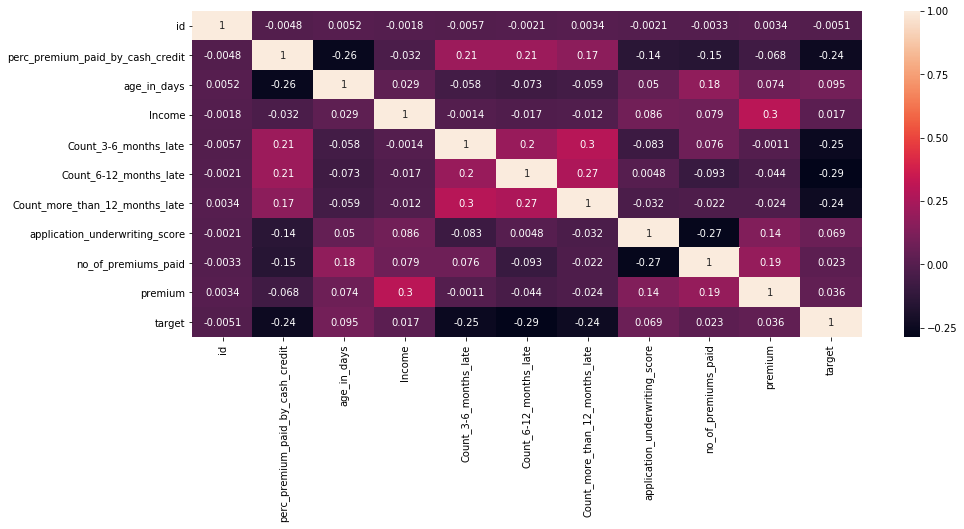

In [7]:
plt.figure(figsize = (15, 6))
sns.heatmap(train_data.corr(), annot = True)

## Data Wrangling 

In [8]:
train_data.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
target                                 0
dtype: int64

In [9]:
test_data.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 31
Count_6-12_months_late                31
Count_more_than_12_months_late        31
application_underwriting_score      1323
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
dtype: int64

In [10]:
for dataset in combine: 
    dataset['age'] = dataset['age_in_days']//365
    dataset.drop(['age_in_days'], axis = 1, inplace = True)
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age
0,110936,0.429,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,33
1,41492,0.010,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,59
2,31300,0.917,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,48
3,19415,0.049,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,42
4,99379,0.052,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,86


In [11]:
train_data[['sourcing_channel', 'target']].groupby('sourcing_channel', as_index = False).mean()

,sourcing_channel,target
0,A,0.945542
1,B,0.935441
2,C,0.924994
3,D,0.916126
4,E,0.924466


### Let's try and fill the missing values

#### Application Under writing score

We might need to make income groups to understand the relations better 

In [12]:
train_data['IncomeBands'] = pd.cut(train_data['Income'], 5)
train_data[['IncomeBands', 'target']].groupby('IncomeBands', as_index = False).count()

,IncomeBands,target
0,"(-66208.57, 18071744.0]",79846
1,"(18071744.0, 36119458.0]",4
2,"(36119458.0, 54167172.0]",2
3,"(54167172.0, 72214886.0]",0
4,"(72214886.0, 90262600.0]",1


Let's standardize our data by using a standard scaler

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(train_data[['Income']])
x_scaled = scaler.transform(train_data[['Income']])
x_scaled

array([[0.00366839],
       [0.00322611],
       [0.00066612],
       ...,
       [0.00311386],
       [0.00016955],
       [0.00283814]])

In [14]:
# print(scaler.mean_)
print(scaler.scale_)

[1.10817359e-08]


In [15]:
train_data['scaled_income'] = x_scaled
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,IncomeBands,scaled_income
0,110936,0.429,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,33,"(-66208.57, 18071744.0]",0.003668
1,41492,0.010,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,59,"(-66208.57, 18071744.0]",0.003226
2,31300,0.917,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,48,"(-66208.57, 18071744.0]",0.000666
3,19415,0.049,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,42,"(-66208.57, 18071744.0]",0.002510
4,99379,0.052,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,86,"(-66208.57, 18071744.0]",0.001935


In [16]:
train_data['IncomeBands'] = pd.cut(train_data['scaled_income'], 5)
train_data[['IncomeBands', 'target']].groupby('IncomeBands', as_index = False).count()

,IncomeBands,target
0,"(-0.001, 0.2]",79846
1,"(0.2, 0.4]",4
2,"(0.4, 0.6]",2
3,"(0.6, 0.8]",0
4,"(0.8, 1.0]",1


### Let's try and deal with outlier values

In [17]:
print(train_data['Income'].mean())
print(train_data['Income'].median())

208847.17117703782
166560.0


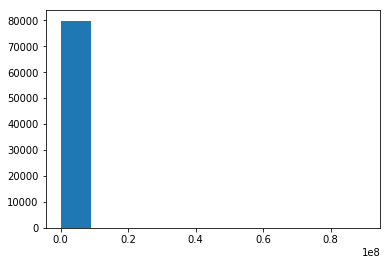

In [18]:
plt.hist(train_data['Income'])
plt.show()

In [19]:
upper_bound = 0.95
lower_bound = 0.1
res = train_data['Income'].quantile([lower_bound, upper_bound])
print(res)

0.10     71200.0
0.95    450050.0
Name: Income, dtype: float64


So, we can collect all the values in this range and let go of the other ones. 

In [20]:
true_index = (train_data['Income'] < res.loc[upper_bound])
true_index

0         True
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
         ...  
79823     True
79824     True
79825     True
79826     True
79827     True
79828     True
79829     True
79830     True
79831     True
79832     True
79833     True
79834     True
79835     True
79836     True
79837     True
79838     True
79839     True
79840    False
79841    False
79842     True
79843     True
79844     True
79845     True
79846     True
79847     True
79848     True
79849     True
79850     True
79851     True
79852     True
Name: Income, Length: 79853, dtype: bool

In [21]:
false_index = ~true_index

In [22]:
no_outlier_data = train_data[true_index].copy()
no_outlier_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,IncomeBands,scaled_income
0,110936,0.429,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,33,"(-0.001, 0.2]",0.003668
1,41492,0.010,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,59,"(-0.001, 0.2]",0.003226
2,31300,0.917,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,48,"(-0.001, 0.2]",0.000666
3,19415,0.049,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,42,"(-0.001, 0.2]",0.002510
4,99379,0.052,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,86,"(-0.001, 0.2]",0.001935


Let's make groups for the new income range

In [23]:
no_outlier_data['IncomeBands'] = pd.cut(no_outlier_data['Income'], 5)
no_outlier_data[['IncomeBands', 'target']].groupby('IncomeBands', as_index = False).count()

,IncomeBands,target
0,"(23603.99, 109232.0]",20493
1,"(109232.0, 194434.0]",26922
2,"(194434.0, 279636.0]",16575
3,"(279636.0, 364838.0]",8587
4,"(364838.0, 450040.0]",3269


In [24]:
combine = [train_data, test_data]
for dataset in combine: 
    dataset.loc[ dataset['Income'] <= 23603.99, 'Income'] = 0
    dataset.loc[(dataset['Income'] > 23603.99) & (dataset['Income'] <= 109232.0), 'Income'] = 1
    dataset.loc[(dataset['Income'] > 109232.0) & (dataset['Income'] <= 194434.0), 'Income'] = 2
    dataset.loc[(dataset['Income'] > 194434.0) & (dataset['Income'] <= 279636.0), 'Income'] = 3
    dataset.loc[(dataset['Income'] > 279636.0) & (dataset['Income'] <= 364838.0), 'Income'] = 4
    dataset.loc[(dataset['Income'] > 364838.0) & (dataset['Income'] <= 450040.0), 'Income'] = 5
    dataset.loc[ dataset['Income'] > 450040.0, 'Income'] = 6
    
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,IncomeBands,scaled_income
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,33,"(-0.001, 0.2]",0.003668
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,59,"(-0.001, 0.2]",0.003226
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,48,"(-0.001, 0.2]",0.000666
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,42,"(-0.001, 0.2]",0.002510
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,86,"(-0.001, 0.2]",0.001935


In [25]:
train_data.loc[false_index, 'Income'] = 5
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,IncomeBands,scaled_income
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,33,"(-0.001, 0.2]",0.003668
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,59,"(-0.001, 0.2]",0.003226
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,48,"(-0.001, 0.2]",0.000666
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,42,"(-0.001, 0.2]",0.002510
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,86,"(-0.001, 0.2]",0.001935


In [26]:
train_data.drop(['IncomeBands', 'scaled_income'], axis = 1, inplace = True)
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,33
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,59
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,48
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,42
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,86


**Let's also make groups for Age**

In [27]:
train_data['AgeBands'] = pd.cut(train_data['age'], 5)
train_data[['AgeBands', 'target']].groupby('AgeBands', as_index = False).count()

,AgeBands,target
0,"(20.918, 37.4]",14314
1,"(37.4, 53.8]",30585
2,"(53.8, 70.2]",26773
3,"(70.2, 86.6]",7531
4,"(86.6, 103.0]",650


In [28]:
for dataset in combine:    
    dataset.loc[ dataset['age'] <= 37.4, 'age'] = 0
    dataset.loc[(dataset['age'] > 37.4) & (dataset['age'] <= 53.8), 'age'] = 1
    dataset.loc[(dataset['age'] > 53.8) & (dataset['age'] <= 70.2), 'age'] = 2
    dataset.loc[(dataset['age'] > 70.2) & (dataset['age'] <= 86.6), 'age'] = 3
    dataset.loc[ dataset['age'] > 86.6, 'age'] = 4
train_data.drop('AgeBands', axis = 1, inplace = True)
combine = [train_data, test_data]
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,0
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,2
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,1
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,1
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,3


In [29]:
train_data[['age', 'application_underwriting_score']].groupby('age').mean()

,application_underwriting_score
age,
0,99.145848
1,98.978552
2,99.057655
3,99.300457
4,99.537480


In [30]:
train_data['PremBand'] = pd.cut(train_data['no_of_premiums_paid'], 5)
train_data[['PremBand', 'application_underwriting_score']].groupby('PremBand').count()

,application_underwriting_score
PremBand,
"(1.942, 13.6]",56830
"(13.6, 25.2]",18944
"(25.2, 36.8]",1023
"(36.8, 48.4]",62
"(48.4, 60.0]",20


In [31]:
print(train_data['application_underwriting_score'].mean())
print(train_data['application_underwriting_score'].std())

99.06729119785102
0.7397990154151102


In [32]:
print(train_data[train_data['sourcing_channel'] == 'A']['application_underwriting_score'].std())
train_data[['sourcing_channel', 'target']].groupby('sourcing_channel', as_index = False).mean()

0.7695318642626707


,sourcing_channel,target
0,A,0.945542
1,B,0.935441
2,C,0.924994
3,D,0.916126
4,E,0.924466


In [33]:
# print(train_data[train_data['sourcing_channel'] == 'C']['application_underwriting_score'].std())
train_data[['sourcing_channel', 'application_underwriting_score']].groupby('sourcing_channel', as_index = False).mean()

,sourcing_channel,application_underwriting_score
0,A,99.102432
1,B,99.055857
2,C,98.979512
3,D,99.038356
4,E,99.067980


In [34]:
train_data[['residence_area_type', 'application_underwriting_score']].groupby('residence_area_type', as_index = False).mean()

,residence_area_type,application_underwriting_score
0,Rural,99.062726
1,Urban,99.070299


We can set the values of underwriting score on the basis of the sourcing channel

In [35]:
train_data.dtypes

id                                     int64
perc_premium_paid_by_cash_credit     float64
Income                                 int64
Count_3-6_months_late                float64
Count_6-12_months_late               float64
Count_more_than_12_months_late       float64
application_underwriting_score       float64
no_of_premiums_paid                    int64
sourcing_channel                      object
residence_area_type                   object
premium                                int64
target                                 int64
age                                    int64
PremBand                            category
dtype: object

In [36]:
combine = [train_data, test_data]
for dataset in combine: 
    mask1 = dataset['application_underwriting_score'].isnull()
    for source in ['A', 'B', 'C', 'D', 'E']:
        mask2 = (dataset['sourcing_channel'] == source)
        source_mean = dataset[dataset['sourcing_channel'] == source]['application_underwriting_score'].mean()
        dataset.loc[mask1 & mask2, 'application_underwriting_score'] = source_mean
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,PremBand
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,0,"(1.942, 13.6]"
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,2,"(13.6, 25.2]"
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,1,"(1.942, 13.6]"
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,1,"(1.942, 13.6]"
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,3,"(1.942, 13.6]"


In [37]:
dataset['application_underwriting_score'].isnull()

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
34194    False
34195    False
34196    False
34197    False
34198    False
34199    False
34200    False
34201    False
34202    False
34203    False
34204    False
34205    False
34206    False
34207    False
34208    False
34209    False
34210    False
34211    False
34212    False
34213    False
34214    False
34215    False
34216    False
34217    False
34218    False
34219    False
34220    False
34221    False
34222    False
34223    False
Name: application_underwriting_score, Length: 34224, dtype: bool

In [38]:
test_data[test_data['Count_3-6_months_late'].isnull()]

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age
661,27504,1.0,1,NaN,NaN,NaN,98.969145,2,C,Urban,0
693,105597,1.0,1,NaN,NaN,NaN,98.969145,2,C,Rural,1
1994,11064,1.0,1,NaN,NaN,NaN,99.043758,2,B,Rural,0
2041,71932,1.0,1,NaN,NaN,NaN,99.104517,2,A,Urban,0
2182,61662,1.0,1,NaN,NaN,NaN,99.104517,2,A,Rural,0
3162,87207,1.0,2,NaN,NaN,NaN,99.890000,2,A,Rural,3
4235,63318,1.0,1,NaN,NaN,NaN,99.104517,2,A,Rural,0
4591,107792,1.0,1,NaN,NaN,NaN,99.104517,2,A,Urban,0
6699,896,1.0,1,NaN,NaN,NaN,99.043758,2,B,Rural,0
8104,60408,1.0,1,NaN,NaN,NaN,99.011623,2,D,Urban,0


 Add  a new variable 'late premium' for late premiums

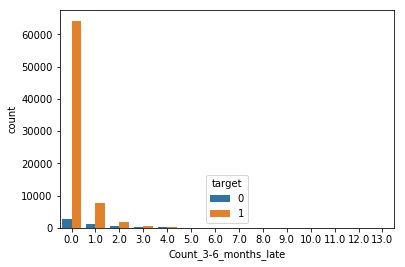

In [39]:
sns.countplot(x = 'Count_3-6_months_late', data = train_data, hue = 'target')

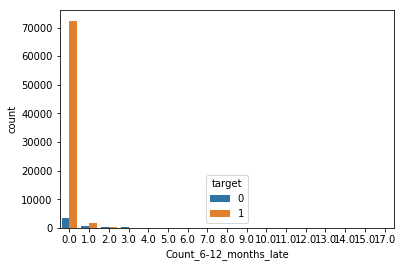

In [40]:
sns.countplot(x = 'Count_6-12_months_late', data = train_data, hue = 'target')

In [41]:
combine = [train_data, test_data]
for dataset in combine: 
    dataset['late_premium'] = 0.0
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,PremBand,late_premium
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,0,"(1.942, 13.6]",0.0
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,2,"(13.6, 25.2]",0.0
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,1,"(1.942, 13.6]",0.0
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,1,"(1.942, 13.6]",0.0
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,3,"(1.942, 13.6]",0.0


In [42]:
combine = [train_data, test_data]
for dataset in combine:
        dataset.loc[(dataset['Count_3-6_months_late'].isnull()),  'late_premium'] = np.NaN
        dataset.loc[(dataset['Count_3-6_months_late'].notnull()), 'late_premium'] = dataset['Count_3-6_months_late'] + dataset['Count_6-12_months_late'] + dataset['Count_more_than_12_months_late']
train_data.head() 

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,PremBand,late_premium
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,0,"(1.942, 13.6]",0.0
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,2,"(13.6, 25.2]",0.0
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,1,"(1.942, 13.6]",6.0
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,1,"(1.942, 13.6]",0.0
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,3,"(1.942, 13.6]",0.0


In [43]:
train_data['target'].corr(train_data['late_premium'])

-0.35639625161362404

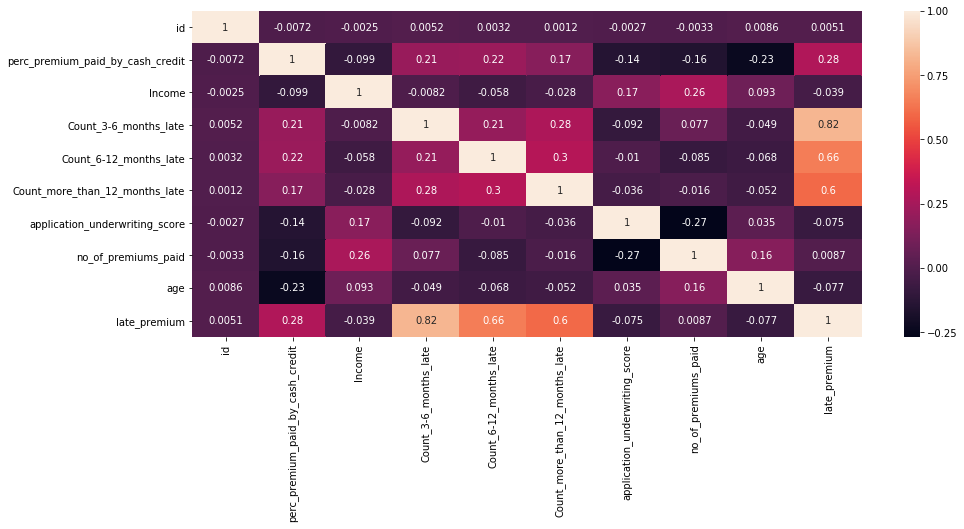

In [44]:
plt.figure(figsize = (15, 6))
sns.heatmap(test_data.corr(), annot = True)

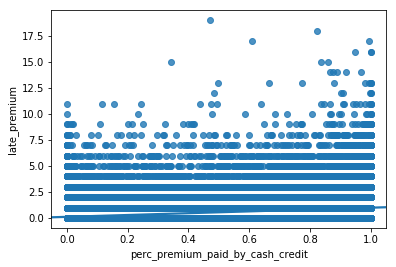

In [45]:
sns.regplot(x = 'perc_premium_paid_by_cash_credit', y = 'late_premium', data = train_data)

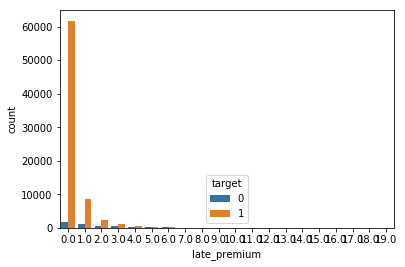

In [46]:
sns.countplot(x = 'late_premium', data = train_data, hue = 'target')

If it's more than 7 then the loan is never sanctioned. So, let's set those values first. 

In [47]:
train_data[['late_premium', 'target']].groupby('late_premium').mean()

,target
late_premium,
0.0,0.971659
1.0,0.890487
2.0,0.780694
3.0,0.695418
4.0,0.579800
5.0,0.510684
6.0,0.441696
7.0,0.487654
8.0,0.455556


In [48]:
# for dataset in [train_data]:
train_data.loc[(train_data['target'] == 0) & (train_data['late_premium'].isnull()),'late_premium'] = 7
train_data.loc[(train_data['target'] == 1) & (train_data['late_premium'].isnull()),'late_premium'] = 2
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,PremBand,late_premium
0,110936,0.429,4,0.0,0.0,0.0,99.02,13,C,Urban,3300,1,0,"(1.942, 13.6]",0.0
1,41492,0.010,4,0.0,0.0,0.0,99.89,21,A,Urban,18000,1,2,"(13.6, 25.2]",0.0
2,31300,0.917,1,2.0,3.0,1.0,98.69,7,C,Rural,3300,0,1,"(1.942, 13.6]",6.0
3,19415,0.049,3,0.0,0.0,0.0,99.57,9,A,Urban,9600,1,1,"(1.942, 13.6]",0.0
4,99379,0.052,3,0.0,0.0,0.0,99.87,12,B,Urban,9600,1,3,"(1.942, 13.6]",0.0


In [49]:
print(train_data.isnull().sum())
print('\n')
print(test_data.isnull().sum())

id                                   0
perc_premium_paid_by_cash_credit     0
Income                               0
Count_3-6_months_late               97
Count_6-12_months_late              97
Count_more_than_12_months_late      97
application_underwriting_score       0
no_of_premiums_paid                  0
sourcing_channel                     0
residence_area_type                  0
premium                              0
target                               0
age                                  0
PremBand                             0
late_premium                         0
dtype: int64


id                                   0
perc_premium_paid_by_cash_credit     0
Income                               0
Count_3-6_months_late               31
Count_6-12_months_late              31
Count_more_than_12_months_late      31
application_underwriting_score       0
no_of_premiums_paid                  0
sourcing_channel                     0
residence_area_type                  0
age       

### Replacing the late_premium value in the test data 

In [50]:
guess_prem = np.zeros(5)
for dataset in [test_data]:
    for i in range(1, 6):
        guess_df = dataset[(dataset['Income'] == i)]['late_premium'].dropna()

        # age_mean = guess_df.mean()
        # age_std = guess_df.std()
        # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        premium_guess = guess_df.median()
        guess_prem[i - 1] = int(premium_guess) 

    for j in range(1, 6):
        dataset.loc[(dataset.late_premium.isnull()) & (dataset.Income == j), 'late_premium'] = guess_prem[j - 1] + 1

    dataset['late_premium'] = dataset['late_premium'].astype(int)

test_data.head(10)

,id,perc_premium_paid_by_cash_credit,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age,late_premium
0,649,0.001,1,0.0,0.0,0.0,99.890000,7,A,Rural,3,0
1,81136,0.124,4,0.0,0.0,0.0,98.930000,19,A,Urban,2,0
2,70762,1.000,2,0.0,0.0,0.0,99.043758,2,B,Urban,1,0
3,53935,0.198,2,0.0,0.0,0.0,99.000000,11,B,Rural,1,0
4,15476,0.041,3,1.0,0.0,0.0,99.170000,14,A,Rural,0,1
5,64797,0.112,3,0.0,0.0,0.0,98.880000,7,B,Rural,1,0
6,67412,0.325,5,6.0,0.0,0.0,99.000000,27,C,Urban,1,6
7,44241,0.362,1,3.0,0.0,0.0,98.400000,14,A,Urban,2,3
8,5069,0.115,4,0.0,0.0,0.0,99.880000,6,D,Rural,2,0
9,16615,0.021,6,0.0,0.0,0.0,99.890000,11,B,Urban,2,0


In [51]:
train_data.drop(['Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'], axis = 1, inplace = True)
test_data.drop(['Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'], axis = 1, inplace = True)

## Conversion to numerical data

In [52]:
# Converting Area Type and sourcing channel to Ordinal Variables
combine = [train_data, test_data]
for dataset in combine: 
    dataset['residence_area_type'] = dataset['residence_area_type'].map( {'Urban' : 1, 'Rural' : 0} )
    dataset['sourcing_channel'] = dataset['sourcing_channel'].map( {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4} )
train_data.head()


,id,perc_premium_paid_by_cash_credit,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,PremBand,late_premium
0,110936,0.429,4,99.02,13,2,1,3300,1,0,"(1.942, 13.6]",0.0
1,41492,0.010,4,99.89,21,0,1,18000,1,2,"(13.6, 25.2]",0.0
2,31300,0.917,1,98.69,7,2,0,3300,0,1,"(1.942, 13.6]",6.0
3,19415,0.049,3,99.57,9,0,1,9600,1,1,"(1.942, 13.6]",0.0
4,99379,0.052,3,99.87,12,1,1,9600,1,3,"(1.942, 13.6]",0.0


Further conversions

In [53]:
train_data['application_underwriting_score'] = train_data['application_underwriting_score']/100
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,PremBand,late_premium
0,110936,0.429,4,0.9902,13,2,1,3300,1,0,"(1.942, 13.6]",0.0
1,41492,0.010,4,0.9989,21,0,1,18000,1,2,"(13.6, 25.2]",0.0
2,31300,0.917,1,0.9869,7,2,0,3300,0,1,"(1.942, 13.6]",6.0
3,19415,0.049,3,0.9957,9,0,1,9600,1,1,"(1.942, 13.6]",0.0
4,99379,0.052,3,0.9987,12,1,1,9600,1,3,"(1.942, 13.6]",0.0


### Let's also work on no of premiums paid

In [54]:
upper_bound = 0.95
res = train_data['no_of_premiums_paid'].quantile([upper_bound])
print(res)


0.95    20.0
Name: no_of_premiums_paid, dtype: float64


In [55]:
true_index = train_data['no_of_premiums_paid'] < res.loc[upper_bound]
false_index = ~true_index
true_index

0         True
1        False
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10       False
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20       False
21        True
22        True
23       False
24        True
25        True
26        True
27        True
28        True
29        True
         ...  
79823     True
79824     True
79825     True
79826     True
79827     True
79828     True
79829     True
79830     True
79831     True
79832     True
79833     True
79834     True
79835     True
79836     True
79837     True
79838     True
79839     True
79840     True
79841     True
79842     True
79843     True
79844     True
79845     True
79846     True
79847     True
79848     True
79849     True
79850     True
79851     True
79852     True
Name: no_of_premiums_paid, Length: 79853, dtype: bool

In [56]:
train_data['PremBand'] = pd.cut(train_data[true_index]['no_of_premiums_paid'], 4)
train_data[['PremBand', 'application_underwriting_score']].groupby('PremBand').count()

,application_underwriting_score
PremBand,
"(1.983, 6.25]",15229
"(6.25, 10.5]",27838
"(10.5, 14.75]",20542
"(14.75, 19.0]",11244


In [57]:
# combine = [train_data, test_data]
# for dataset in combine: 
#     dataset.loc[ dataset['no_of_premiums_paid'] <= 6.25, 'no_of_premiums_paid'] = 0
#     dataset.loc[(dataset['no_of_premiums_paid'] > 6.25) & (dataset['no_of_premiums_paid'] <= 10.5), 'no_of_premiums_paid'] = 1
#     dataset.loc[(dataset['no_of_premiums_paid'] > 10.50) & (dataset['no_of_premiums_paid'] <= 14.75), 'no_of_premiums_paid'] = 2
#     dataset.loc[(dataset['no_of_premiums_paid'] > 14.75) & (dataset['no_of_premiums_paid'] <= 19.0), 'no_of_premiums_paid'] = 3
#     dataset.loc[ dataset['no_of_premiums_paid'] > 19.0, 'no_of_premiums_paid'] = 4
    
# train_data.drop('PremBand', axis = 1, inplace = True)
# train_data.head()

### We also need to convert the premium column

In [58]:
upper_bound = 0.90
res = train_data['premium'].quantile([upper_bound])
print(res)
true_index = train_data['premium'] < res.loc[upper_bound]
false_index = ~true_index
true_index

0.9    22200.0
Name: premium, dtype: float64


0         True
1         True
2         True
3         True
4         True
5        False
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21       False
22        True
23        True
24        True
25        True
26        True
27        True
28       False
29        True
         ...  
79823     True
79824     True
79825     True
79826     True
79827     True
79828     True
79829     True
79830     True
79831    False
79832     True
79833    False
79834     True
79835     True
79836     True
79837     True
79838     True
79839     True
79840    False
79841    False
79842     True
79843     True
79844     True
79845    False
79846     True
79847     True
79848     True
79849    False
79850     True
79851     True
79852     True
Name: premium, Length: 79853, dtype: bool

In [59]:
train_data['PremBand'] = pd.cut(train_data[true_index]['premium'], 4)
train_data[['PremBand', 'target']].groupby('PremBand').count()

,target
PremBand,
"(1181.1, 5925.0]",30760
"(5925.0, 10650.0]",18613
"(10650.0, 15375.0]",13380
"(15375.0, 20100.0]",8315


In [60]:
test_data.head()

,id,perc_premium_paid_by_cash_credit,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age,late_premium
0,649,0.001,1,99.890000,7,0,0,3,0
1,81136,0.124,4,98.930000,19,0,1,2,0
2,70762,1.000,2,99.043758,2,1,1,1,0
3,53935,0.198,2,99.000000,11,1,0,1,0
4,15476,0.041,3,99.170000,14,0,0,0,1


In [61]:
combine = [train_data]
for dataset in combine: 
    dataset.loc[ dataset['premium'] <= 5925.0, 'premium'] = 0
    dataset.loc[(dataset['premium'] > 5925.00) & (dataset['premium'] <= 10650.0), 'premium'] = 1
    dataset.loc[(dataset['premium'] > 10650.0) & (dataset['premium'] <= 15375.0), 'premium'] = 2
    dataset.loc[(dataset['premium'] > 15375.0) & (dataset['premium'] <= 201200.0), 'premium'] = 3
    dataset.loc[ dataset['premium'] > 201200.0, 'premium'] = 4
train_data.drop('PremBand', axis = 1, inplace = True)
train_data.head()
combine = [train_data, test_data]

Finally convert percentage premium paid

In [62]:
train_data['PremBand'] = pd.cut(train_data['perc_premium_paid_by_cash_credit'], 4)
train_data[['PremBand', 'target']].groupby('PremBand').mean()

,target
PremBand,
"(-0.001, 0.25]",0.976381
"(0.25, 0.5]",0.945482
"(0.5, 0.75]",0.900194
"(0.75, 1.0]",0.817460


In [63]:
combine = [train_data, test_data]
for dataset in combine: 
    dataset.loc[ dataset['perc_premium_paid_by_cash_credit'] <= 0.25, 'perc_premium_paid_by_cash_credit'] = 0
    dataset.loc[(dataset['perc_premium_paid_by_cash_credit'] > 0.25) & (dataset['perc_premium_paid_by_cash_credit'] <= 0.5), 'perc_premium_paid_by_cash_credit'] = 1
    dataset.loc[(dataset['perc_premium_paid_by_cash_credit'] > 0.5) & (dataset['perc_premium_paid_by_cash_credit'] <= 0.75), 'perc_premium_paid_by_cash_credit'] = 2
    dataset.loc[ dataset['perc_premium_paid_by_cash_credit'] > 0.75, 'perc_premium_paid_by_cash_credit'] = 3
train_data.drop('PremBand', axis = 1, inplace = True)
train_data.head()

,id,perc_premium_paid_by_cash_credit,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,target,age,late_premium
0,110936,3.0,4,0.9902,13,2,1,0,1,0,0.0
1,41492,0.0,4,0.9989,21,0,1,3,1,2,0.0
2,31300,3.0,1,0.9869,7,2,0,0,0,1,6.0
3,19415,0.0,3,0.9957,9,0,1,1,1,1,0.0
4,99379,0.0,3,0.9987,12,1,1,1,1,3,0.0


In [64]:
test_data.head()

,id,perc_premium_paid_by_cash_credit,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age,late_premium
0,649,0.0,1,99.890000,7,0,0,3,0
1,81136,0.0,4,98.930000,19,0,1,2,0
2,70762,3.0,2,99.043758,2,1,1,1,0
3,53935,0.0,2,99.000000,11,1,0,1,0
4,15476,0.0,3,99.170000,14,0,0,0,1


In [65]:
train_data[['perc_premium_paid_by_cash_credit', 'late_premium']] = train_data[['perc_premium_paid_by_cash_credit', 'late_premium']].astype(int)
test_data[['perc_premium_paid_by_cash_credit']] = test_data[['perc_premium_paid_by_cash_credit']].astype(int)
test_data.head()

,id,perc_premium_paid_by_cash_credit,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age,late_premium
0,649,0,1,99.890000,7,0,0,3,0
1,81136,0,4,98.930000,19,0,1,2,0
2,70762,3,2,99.043758,2,1,1,1,0
3,53935,0,2,99.000000,11,1,0,1,0
4,15476,0,3,99.170000,14,0,0,0,1


## Building our models

Let's make the data splits

In [66]:
X_train = train_data.drop(['id', 'target', 'premium', 'perc_premium_paid_by_cash_credit'], axis = 1).copy()
y_train = train_data['target']
X_test = test_data.drop(['id', 'perc_premium_paid_by_cash_credit'], axis = 1).copy()
print(X_train.shape, y_train.shape, X_test.shape)

(79853, 7) (79853,) (34224, 7)


In [67]:
X_train.head()

,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age,late_premium
0,4,0.9902,13,2,1,0,0
1,4,0.9989,21,0,1,2,0
2,1,0.9869,7,2,0,1,6
3,3,0.9957,9,0,1,1,0
4,3,0.9987,12,1,1,3,0


In [68]:
X_test.head()

,Income,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,age,late_premium
0,1,99.890000,7,0,0,3,0
1,4,98.930000,19,0,1,2,0
2,2,99.043758,2,1,1,1,0
3,2,99.000000,11,1,0,1,0
4,3,99.170000,14,0,0,0,1


### Logistic Regression 

In [69]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


93.93

In [70]:
coeff_data = pd.DataFrame(train_data.columns.delete(0))
coeff_data.columns = ['Feature']
coeff_data['Correlation'] = pd.Series(logreg.coef_[0])
coeff_data.sort_values(by = 'Correlation', ascending = False)

,Feature,Correlation
1,Income,2.702844
5,residence_area_type,0.328253
0,perc_premium_paid_by_cash_credit,0.185581
4,sourcing_channel,0.017926
2,application_underwriting_score,-0.006067
3,no_of_premiums_paid,-0.094110
6,premium,-0.660658
7,target,NaN
8,age,NaN
9,late_premium,NaN


In [71]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

92.39

k - Nearest Neighbours

In [72]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

94.6

**Perceptron Algorithm**

In [73]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

93.74

In [74]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

93.89

In [75]:
# Decision Tree

decision_tree = DecisionTreeClassifier(max_depth = 7)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

94.11

In [76]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators = 10)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

98.85

In [77]:
pred_values = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
pred_values.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,98.85
0,KNN,94.60
6,Decision Tree,94.11
1,Logistic Regression,93.93
5,Stochastic Gradient Decent,93.89
4,Perceptron,93.74
3,Naive Bayes,92.39


In [78]:
submission = pd.DataFrame({
        "id": test_data["id"],
        "target": y_pred
    })
submission.to_csv('submission.csv', index=False)

In [79]:
submission.describe()

,id,target
count,34224.000000,34224.000000
mean,56739.956376,0.964849
std,32935.402647,0.184163
min,1.000000,0.000000
25%,28254.750000,1.000000
50%,56488.000000,1.000000
75%,85386.250000,1.000000
max,114077.000000,1.000000
